# Bayesian Network and Experimental Design

# Libraries

In [36]:
!pip install pybbn

In [37]:
import pybbn
import pandas as pd
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx 
import matplotlib.pyplot as plt
%matplotlib inline
import random
import sys

from utils_sys import Printer

from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
from pybbn.sampling.sampling import LogicSampler

from scipy.stats import binom
import numpy as np
np.seterr(invalid='ignore')
import plotly
import plotly.io as pio
import chart_studio
import chart_studio.plotly as cspy
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from urllib.request import urlopen
import json

import seaborn as sns 

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

username = 'vishalgattani' # your username\n",
api_key = 'WSy2EFPTbxYYm3Rmcx53' # your api key - go to profile > settings > regenerate key\n",
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)


# Functions

In [38]:
def getBinomProb(total_exp_runs,p):
    return list(binom.pmf(list(range(total_exp_runs + 1)),total_exp_runs, p))

def evidence(join_tree,ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
def resetEvidence(join_tree):
    join_tree.unobserve_all()
    
def print_probs(join_tree):
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node.to_dict())
        print("Values:")
        print(potential)
        print('----------------')
        
    print("="*90)
        
def print_probs_top_node(join_tree):
    for node in join_tree.get_bbn_nodes():
        if (node.to_dict()['variable']['id']==0):
            potential = join_tree.get_bbn_potential(node)
            df = potential_to_df(join_tree.get_bbn_potential(node))
#             display(df)
            return df
            
def potential_to_df(p):
    data = []
    for pe in p.entries:
        try:
            v = pe.entries.values()[0]
        except:
            v = list(pe.entries.values())[0]
        p = pe.value
        t = (v, p)
        data.append(t)
    return pd.DataFrame(data, columns=['val', 'p'])

def potentials_to_dfs(join_tree):
    data = []
    for node in join_tree.get_bbn_nodes():
        name = node.variable.name
        df = potential_to_df(join_tree.get_bbn_potential(node))
        display(df)
        t = (name, df)
        data.append(t)
    return data

def drawBBN(bbn):
    n, d = bbn.to_nx_graph()
    pos = nx.spring_layout(n)
    nx.draw_spring(n, with_labels=True,labels=d)
    ax = plt.gca()
    
    plt.show()

def plotROC(p,r,fpr_tree, tpr_tree,fpr_lr, tpr_lr,fpr_lrl2, tpr_lrl2,fpr_nb, tpr_nb):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr_tree, y=tpr_tree, mode="markers+lines",name='DT'))
    fig.add_trace(go.Scatter(x=fpr_lr, y=tpr_lr, mode="markers+lines",name='LR'))
    fig.add_trace(go.Scatter(x=fpr_lrl2, y=tpr_lrl2, mode="markers+lines",name='LR(L2)'))
#     fig.add_trace(go.Scatter(x=fpr_nb, y=tpr_nb, mode="markers+lines",name='NB'))
    fig.update_layout(hovermode="x",title='Receiver Operating Characteristic '+"p="+str(p)+",r="+str(r))
    fig.update_xaxes(title_text='TPR')
    fig.update_yaxes(title_text='FPR')
    fig.show()

# Bayesian Network using `pybbn`

In [39]:
threshold_num_runs = 2 # rule
total_exp_runs = 3

p = 0.8
r = 0.01

exp_T = getBinomProb(total_exp_runs,p)
exp_F = getBinomProb(total_exp_runs,r)


exp_dict = {"True":exp_T,"False":exp_F}
exp_cpt = pd.DataFrame(exp_dict)

test_keys = []
test_values = []

for i in range(total_exp_runs+1):
    test_keys.append(str(i))
    if i >= threshold_num_runs:
        test_values.append([1,0])
    else:
        test_values.append([0,1])

test_results_dict = dict(zip(test_keys, test_values))
test_results_cpt = pd.DataFrame(test_results_dict) 
test_results_cpt["States"] = ['Correct','Incorrect']
test_results_cpt.set_index("States",inplace=True)


# Create nodes by manually typing in probabilities
test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

bbn = Bbn() \
    .add_node(algo) \
    .add_node(exp1) \
    .add_node(test_results) \
    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))
join_tree = InferenceController.apply(bbn)

# Plotting the BBN

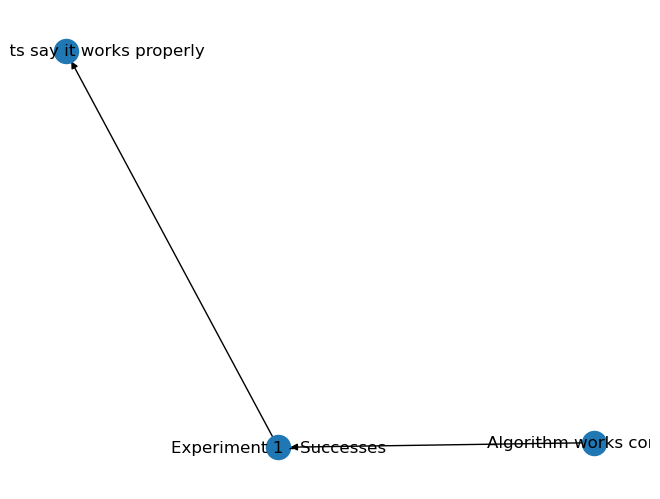

In [40]:
drawBBN(bbn)  

# Printing values of nodes within BBN without setting evidence

In [41]:
print_probs(join_tree)

Node: {'probs': [0.007999999999999995, 0.0960000000000001, 0.3840000000000001, 0.5120000000000001, 0.970299, 0.02940300000000001, 0.000297, 1.0000000000000002e-06], 'variable': {'id': 1, 'name': 'Experiment 1 - Successes', 'values': Index(['0', '1', '2', '3'], dtype='object')}}
Values:
1=0|0.48915
1=1|0.06270
1=2|0.19215
1=3|0.25600
----------------
Node: {'probs': [0, 1, 0, 1, 1, 0, 1, 0], 'variable': {'id': 0, 'name': 'Test Results say it works properly', 'values': ['Correct', 'Incorrect']}}
Values:
0=Correct|0.44815
0=Incorrect|0.55185
----------------
Node: {'probs': [0.5, 0.5], 'variable': {'id': 2, 'name': 'Algorithm works correctly', 'values': ['True', 'False']}}
Values:
2=True|0.50000
2=False|0.50000
----------------


# Setting evidence in BBN

In [42]:
evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
print_probs(join_tree)
df = print_probs_top_node(join_tree)
display(df)
resetEvidence(join_tree)

Node: {'probs': [0.007999999999999995, 0.0960000000000001, 0.3840000000000001, 0.5120000000000001, 0.970299, 0.02940300000000001, 0.000297, 1.0000000000000002e-06], 'variable': {'id': 1, 'name': 'Experiment 1 - Successes', 'values': Index(['0', '1', '2', '3'], dtype='object')}}
Values:
1=0|0.00800
1=1|0.09600
1=2|0.38400
1=3|0.51200
----------------
Node: {'probs': [0, 1, 0, 1, 1, 0, 1, 0], 'variable': {'id': 0, 'name': 'Test Results say it works properly', 'values': ['Correct', 'Incorrect']}}
Values:
0=Correct|0.89600
0=Incorrect|0.10400
----------------
Node: {'probs': [0.5, 0.5], 'variable': {'id': 2, 'name': 'Algorithm works correctly', 'values': ['True', 'False']}}
Values:
2=True|1.00000
2=False|0.00000
----------------


,val,p
0,Correct,0.896
1,Incorrect,0.104


# Generating graphs

- Setting `r` as a fraction of `p`.
- Changing `threshold_num_runs` from `1...n` where `n` is experiment runs.
- Gathering false positives and true positives from the above methods for a certain `p,r` combination.

# False Negatives and False Positives

- False negative (FN): The probability of node “test results say it works properly” is `incorrect` given the node “Algorithm works correctly” is `True`. 

- False Positive (FP): The probability of node “test results say it works properly” is `correct` given the node “Algorithm works correctly” is `False`. 

In [43]:
def getFPTN(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'False', 1.0)
    df = print_probs_top_node(join_tree)
    resetEvidence(join_tree)
    dffp = df[df['val']=='Correct']['p']
    dftn = df[df['val']=='Incorrect']['p']
    return dffp,dftn
    
def getFNTP(join_tree):
    evidence(join_tree,'ev1', 'Algorithm works correctly', 'True', 1.0)
    df = print_probs_top_node(join_tree)
    resetEvidence(join_tree)
    dffn = df[df['val']=='Incorrect']['p']
    dftp = df[df['val']=='Correct']['p']
    return dffn,dftp

In [44]:
threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 4

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = list(np.linspace(0,1,11))
proportionality_factor = list(np.linspace(0.1,1,10))

row = []

for total_exp_runs in total_exp_runs_list:
    for threshold_num_runs in range(1,total_exp_runs+1):
        for k in proportionality_factor:
            for p in p_list:
                r = k*p
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df)    


02/28/2023

# TP vs FP

Plotting the `True Positive` vs `False Positive` while varying `p`,`r` and `threshold_exp`.

In [ ]:
dfs = df.groupby(['n_exp','threshold_exp'])
fig = go.Figure()
for i in dfs:
    i[1]['groups'] = np.floor_divide(i[1].index, len(p_list)).astype(str)
#     print(i[1]['groups'].values.tolist())
    i[1]['k'] = i[1]['groups'].apply(lambda d: proportionality_factor[int(d)%len(proportionality_factor)])
#     display(i[1])
    i[1]['threshold_exp'] = i[1]['threshold_exp'].astype('string')
    fig = px.line(i[1], x="fp", y="tp", hover_data=['n_exp','threshold_exp','p','r'],color='k',markers=True)
    fig.update_layout(title_text="{Number of experiments:"+str(i[1]['n_exp'].unique()[0])+"}{Threshold Runs:"+str(i[1]['threshold_exp'].unique()[0])+"}")
    fig.show()


# Observations

- As the threshold for number of experiments (`threshold_exp`) increases, the `false positive` rate decreases. This is intuitive as it is less probable that the node `Test Results say it works properly` states `correct` when `Algorithm works properly` is `false.
- When the proportionality constant `k` in the equation `r=k*p` is high, the `True Positive` vs `False Positive` becomes a linear relationship. It is also the case when `Number of experiments` equals the threshold for number of experiments considered for the success of the test.

03/01/2023
- Pick a particular combination of (p, r), where p is large but less than 1, and r is small (but not too small), and see how the P{TP} and P{FP} change as a function of the number of tests and the threshold.

In [58]:
# threshold_num_runs = 2 # rule
min_exp_runs = 3
max_exp_runs = 15

total_exp_runs_list = list(range(min_exp_runs,max_exp_runs+1))

p_list = [0.9]
p = p_list[0]
r_list = [0.25,0.5,0.75]

row = []

for total_exp_runs in total_exp_runs_list:
    
    for threshold_num_runs in range(1,total_exp_runs+1):
            if total_exp_runs%3!=0:
                continue
            else: pass
            # for p in p_list:
            for r in r_list:
                
                # r = 0.45
#                 print("p(successful run|algo = T):",p)
#                 print("p(successful run|algo = F):",r," r = ",k,"*","p")
                exp_T = getBinomProb(total_exp_runs,p)
                exp_F = getBinomProb(total_exp_runs,r)
                exp_dict = {"True":exp_T,"False":exp_F}
                exp_cpt = pd.DataFrame(exp_dict)
                test_keys = []
                test_values = []

                for i in range(total_exp_runs+1):
                    test_keys.append(str(i))
                    if i >= threshold_num_runs:
                        test_values.append([1,0])
                    else:
                        test_values.append([0,1])

                test_results_dict = dict(zip(test_keys, test_values))
                test_results_cpt = pd.DataFrame(test_results_dict) 
                test_results_cpt["States"] = ['Correct','Incorrect']
                test_results_cpt.set_index("States",inplace=True)
                
                # display(test_results_cpt)


                # Create nodes by manually typing in probabilities
                test_results = BbnNode(Variable(0, 'Test Results say it works properly', test_results_cpt.index.values.tolist()), np.ndarray.flatten(test_results_cpt.values.transpose()).tolist())
                exp1 = BbnNode(Variable(1, 'Experiment 1 - Successes', test_results_cpt.columns), exp_T+exp_F)
                algo = BbnNode(Variable(2, 'Algorithm works correctly', ["True","False"]), [0.5,0.5])

                bbn = Bbn() \
                    .add_node(algo) \
                    .add_node(exp1) \
                    .add_node(test_results) \
                    .add_edge(Edge(algo, exp1, EdgeType.DIRECTED)) \
                    .add_edge(Edge(exp1, test_results, EdgeType.DIRECTED))

                join_tree = InferenceController.apply(bbn)

                dffp,dftn = getFPTN(join_tree)
                dffn,dftp = getFNTP(join_tree)
                
#                 print("FP : P(Test=T|Algo=F)=",dffp.tolist())
#                 print("TN : P(Test=F|Algo=F)=",dftn.tolist())
#                 print("FN : P(Test=F|Algo=T)=",dffn.tolist())
#                 print("TP : P(Test=T|Algo=T)=",dftp.tolist())

                fp = dffp.tolist()[0]
                tn = dftn.tolist()[0]
                fn = dffn.tolist()[0]
                tp = dftp.tolist()[0]

                data = [total_exp_runs,threshold_num_runs,p,r,fp,tn,fn,tp]
                row.append(data)
#                 print("+"*80)
                
    checkdf = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
#     display(checkdf)
    
df = pd.DataFrame(row, columns = ['n_exp','threshold_exp','p','r','fp','tn','fn','tp'])
# display(df.head())    


# Trend of `FP` and `TP` as `n_exp` increases with fixed `threshold_exp`

# Number of experiments vs Threshold Runs 

In [51]:
# fig = go.Figure()
# fig = px.line(df, x="fp", y="tp", hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
# fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
# # fig.show()

# Observations

- For `n_exp = 7`, when the `threshold_exp` is either `5` or `6`:
    - `tp` is 0.974 and 0.85 respectively. 
    - `fp` is 0.096 and 0.0085 respectively.
- For `n_exp = 8`, when the `threshold_exp` is `6`:
    - `tp` is 0.9619.
    - `fp` is 0.049.

As number of experiments to be performed increases, the curves become steeper as `threshold_exp` increases and the `tp` values decreases. `fp` values increase as `threshold_exp` decrease.

03/02/2023

- Separate plots (one curve per plot) (e.g., n = 3, 6, 9, 12, 15) and labelled the points with the threshold values.

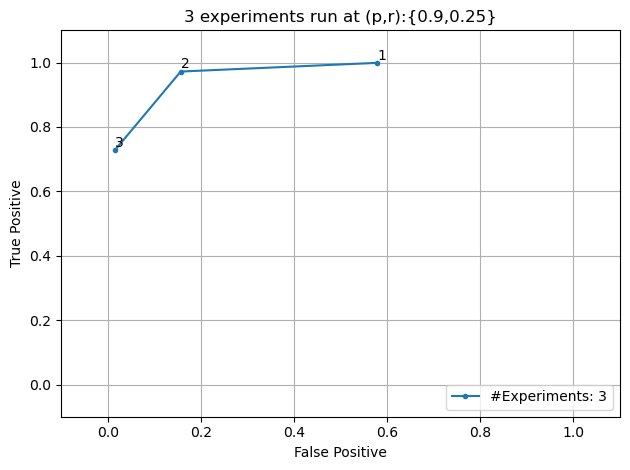

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
3,3.0,2.0,0.9,0.25,0.15625,0.84375,0.028,0.972,0.158739


 TP closest to the perfect classifier: 0.972
 FP closest to the perfect classifier: 0.156


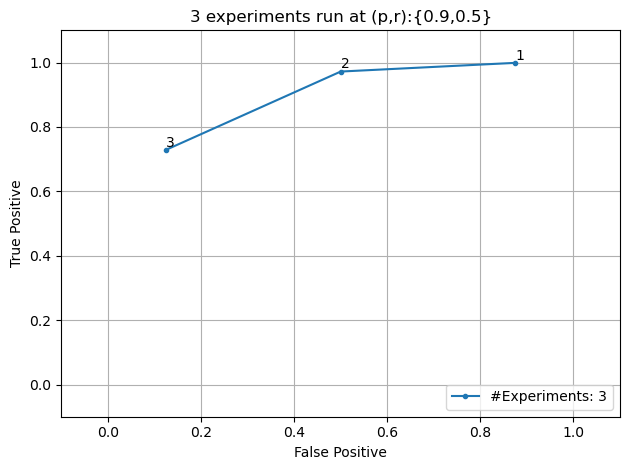

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
7,3.0,3.0,0.9,0.5,0.125,0.875,0.271,0.729,0.298439


 TP closest to the perfect classifier: 0.729
 FP closest to the perfect classifier: 0.125


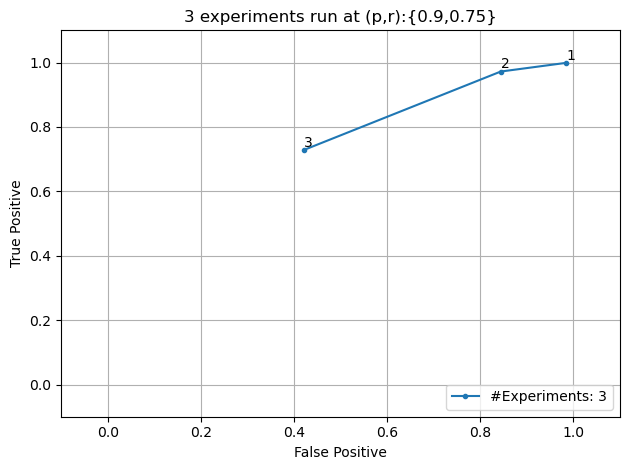

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
8,3.0,3.0,0.9,0.75,0.421875,0.578125,0.271,0.729,0.501418


 TP closest to the perfect classifier: 0.729
 FP closest to the perfect classifier: 0.422


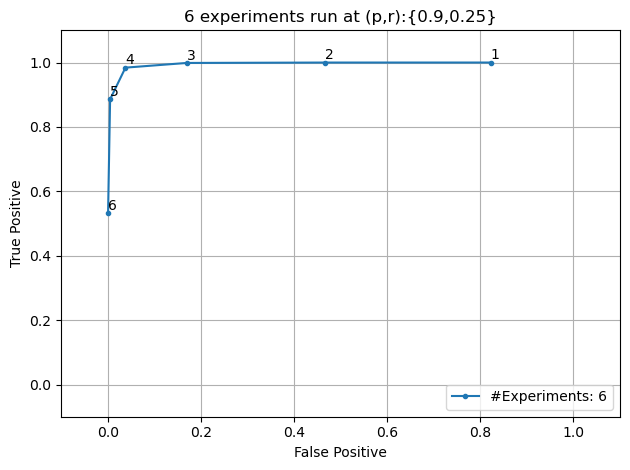

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
18,6.0,4.0,0.9,0.25,0.037598,0.962402,0.01585,0.98415,0.040802


 TP closest to the perfect classifier: 0.984
 FP closest to the perfect classifier: 0.038


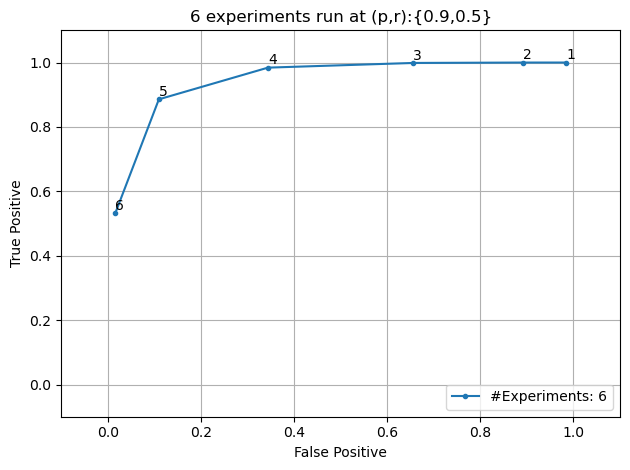

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
22,6.0,5.0,0.9,0.5,0.109375,0.890625,0.114265,0.885735,0.158175


 TP closest to the perfect classifier: 0.886
 FP closest to the perfect classifier: 0.109


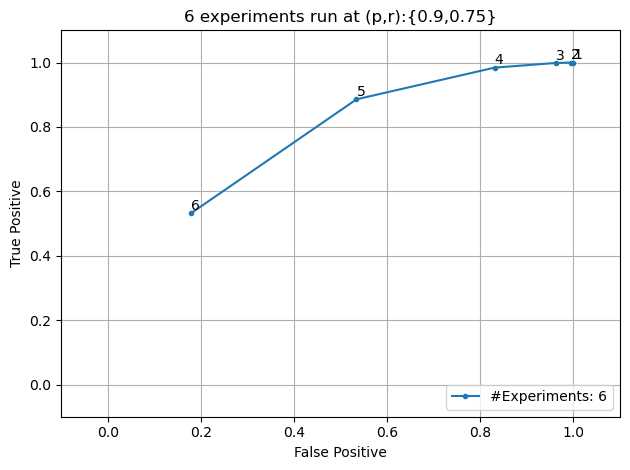

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
26,6.0,6.0,0.9,0.75,0.177979,0.822021,0.468559,0.531441,0.501222


 TP closest to the perfect classifier: 0.531
 FP closest to the perfect classifier: 0.178


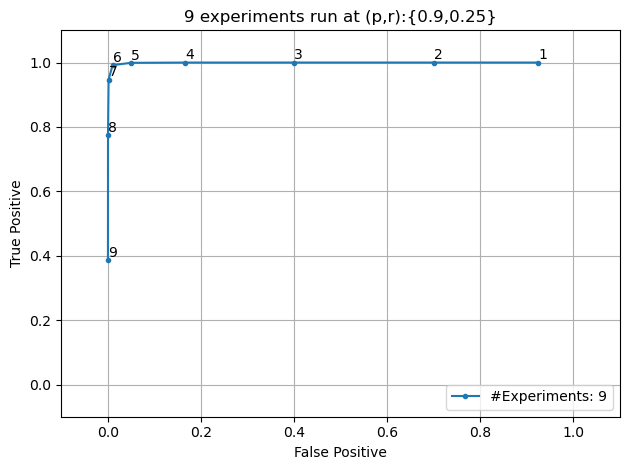

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
42,9.0,6.0,0.9,0.25,0.009995,0.990005,0.008331,0.991669,0.013011


 TP closest to the perfect classifier: 0.992
 FP closest to the perfect classifier: 0.010


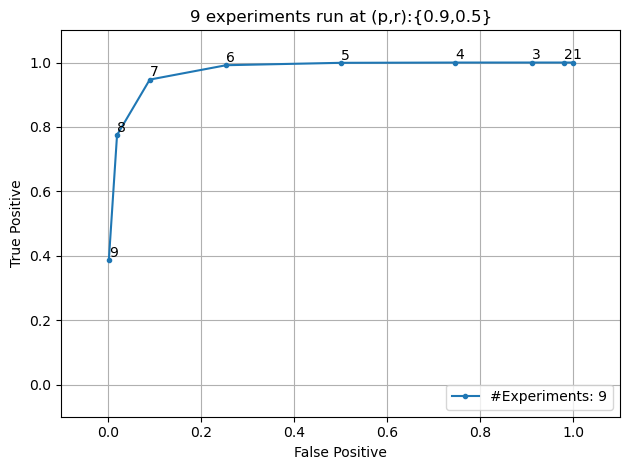

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
46,9.0,7.0,0.9,0.5,0.089844,0.910156,0.052972,0.947028,0.104297


 TP closest to the perfect classifier: 0.947
 FP closest to the perfect classifier: 0.090


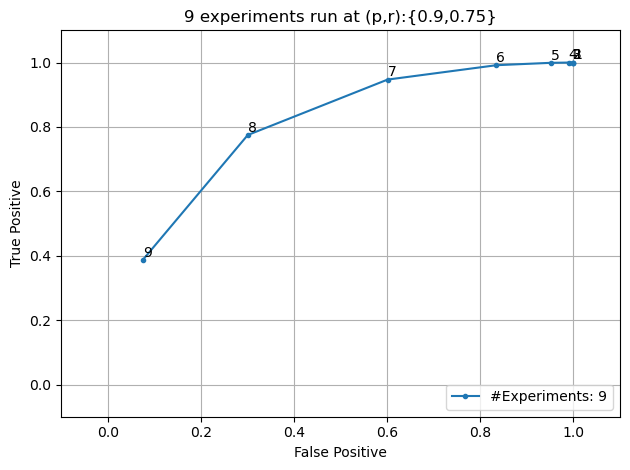

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
50,9.0,8.0,0.9,0.75,0.300339,0.699661,0.225159,0.774841,0.375366


 TP closest to the perfect classifier: 0.775
 FP closest to the perfect classifier: 0.300


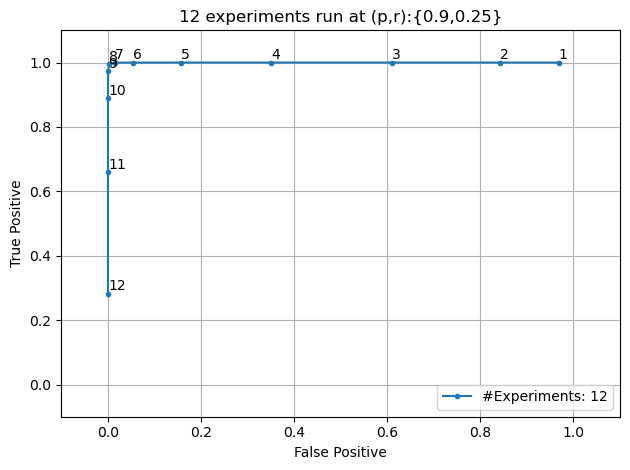

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
75,12.0,8.0,0.9,0.25,0.002782,0.997218,0.004329,0.995671,0.005146


 TP closest to the perfect classifier: 0.996
 FP closest to the perfect classifier: 0.003


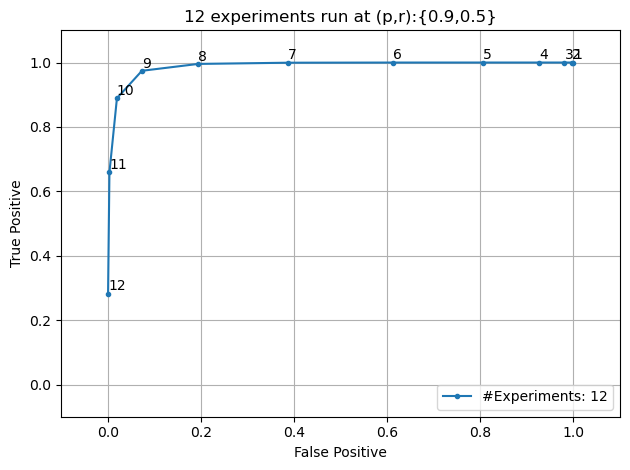

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
79,12.0,9.0,0.9,0.5,0.072998,0.927002,0.025637,0.974363,0.077369


 TP closest to the perfect classifier: 0.974
 FP closest to the perfect classifier: 0.073


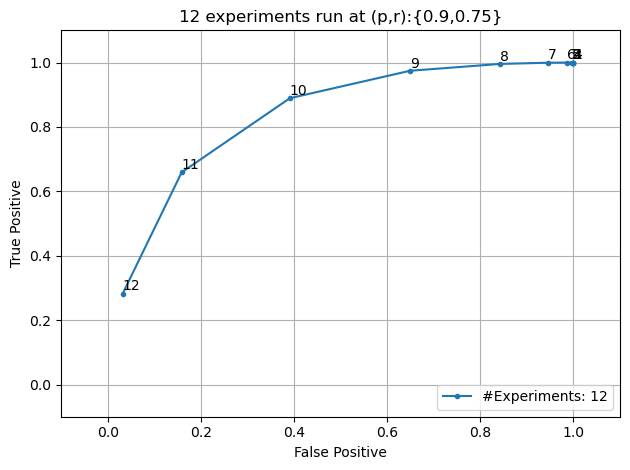

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
86,12.0,11.0,0.9,0.75,0.158382,0.841618,0.340998,0.659002,0.375984


 TP closest to the perfect classifier: 0.659
 FP closest to the perfect classifier: 0.158


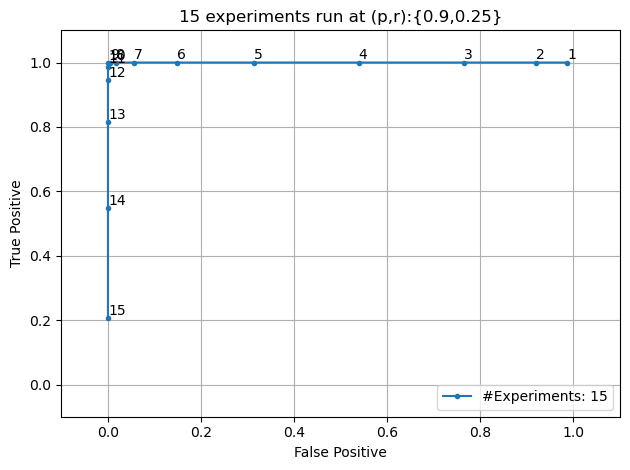

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
117,15.0,10.0,0.9,0.25,0.000795,0.999205,0.00225,0.99775,0.002386


 TP closest to the perfect classifier: 0.998
 FP closest to the perfect classifier: 0.001


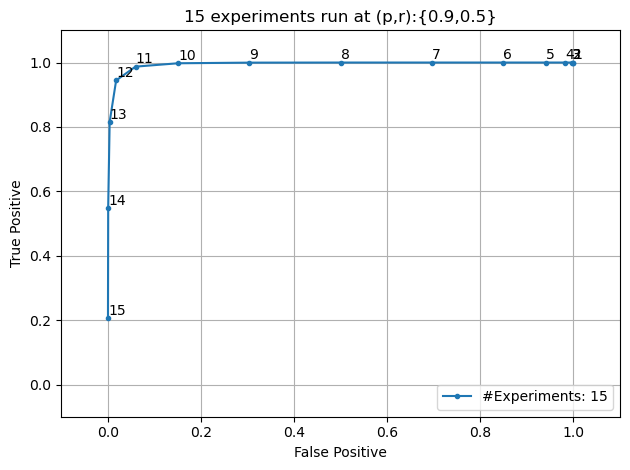

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
124,15.0,12.0,0.9,0.5,0.017578,0.982422,0.055556,0.944444,0.05827


 TP closest to the perfect classifier: 0.944
 FP closest to the perfect classifier: 0.018


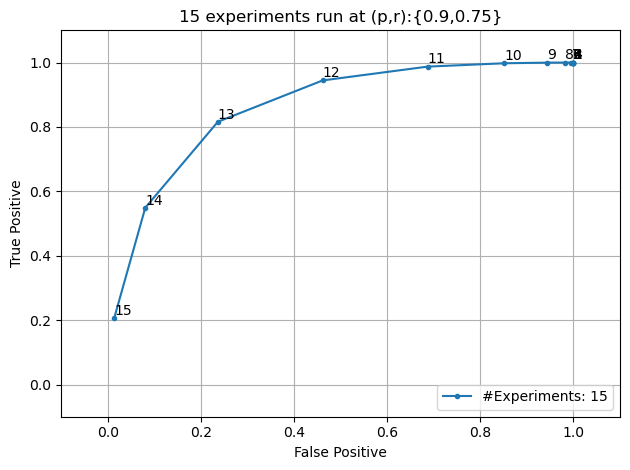

,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP,distances
128,15.0,13.0,0.9,0.75,0.236088,0.763912,0.184061,0.815939,0.299359


 TP closest to the perfect classifier: 0.816
 FP closest to the perfect classifier: 0.236


,Number of Experiments,Threshold number of successes,p,r,FP,TN,FN,TP
0,3.0,2.0,0.9,0.25,0.156250,0.843750,0.028000,0.972000
1,3.0,3.0,0.9,0.50,0.125000,0.875000,0.271000,0.729000
2,3.0,3.0,0.9,0.75,0.421875,0.578125,0.271000,0.729000
3,6.0,4.0,0.9,0.25,0.037598,0.962402,0.015850,0.984150
4,6.0,5.0,0.9,0.50,0.109375,0.890625,0.114265,0.885735
5,6.0,6.0,0.9,0.75,0.177979,0.822021,0.468559,0.531441
6,9.0,6.0,0.9,0.25,0.009995,0.990005,0.008331,0.991669
7,9.0,7.0,0.9,0.50,0.089844,0.910156,0.052972,0.947028
8,9.0,8.0,0.9,0.75,0.300339,0.699661,0.225159,0.774841
9,12.0,8.0,0.9,0.25,0.002782,0.997218,0.004329,0.995671


In [63]:
dfs = df.groupby(['n_exp','p','r'])   
fig = go.Figure()
best_dfs = []
for i in dfs:
#     display(i[1])
#     fig = go.Figure()
#     fig = px.line(i[1], x="fp", y="tp",text='threshold_exp',hover_data=['n_exp','threshold_exp','p','r'],color='n_exp',markers=True)
#     fig.update_traces(textposition='top center')
#     fig.update_layout(title_text="{Number of experiments vs Threshold Runs at (p,r):{"+str(p)+","+str(r)+"}")
#     fig.show()
    # print(i[1].columns)
    # calculate difference between max and min values
    fpr = i[1].fp.to_numpy()
    tpr = i[1].tp.to_numpy()
    distances = [np.sqrt((1 - tpr[i])**2 + fpr[i]**2) for i in range(len(fpr))]
    i[1]["distances"] = distances
    # find index of the point with minimum distance
    min_index = np.argmin(distances)
    # get the corresponding values of FP and TP
    best_fp = fpr[min_index]
    best_tp = tpr[min_index]
    # find the row with the least value in the 'Salary' column
    best = i[1].loc[i[1]['distances'].idxmin()].to_frame().transpose()
    best.columns = ["Number of Experiments","Threshold number of successes","p","r","FP","TN","FN","TP","distances"]
    
    p = i[1].p.unique().tolist()[0]
    r = i[1].r.unique().tolist()[0]
    
    plt.plot(i[1].fp,i[1].tp,marker=".")
    for j in range(len(i[1])):
#         print(j,(i[1].iloc[j].fp), (i[1].iloc[j].tp))
        plt.annotate(str(i[1].threshold_exp.tolist()[j]), ((i[1].iloc[j].fp), (i[1].iloc[j].tp)+0.01))
    plt.legend(["#Experiments: "+str(i[1].n_exp.unique().tolist()[0])]  ,loc='lower right')
    plt.xlabel("False Positive")
    plt.ylabel("True Positive")
    plt.title(str(i[1].n_exp.unique().tolist()[0])+" experiments run at (p,r):{"+str(p)+","+str(r)+"}")
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    display(best)
    best_dfs.append(best)
    Printer.green(f"TP closest to the perfect classifier: {best_tp:.3f}")
    Printer.orange(f"FP closest to the perfect classifier: {best_fp:.3f}")
    
result = pd.concat(best_dfs, axis=0, ignore_index=True)
# drop a column
result = result.drop('distances', axis=1)
display(result)